# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [ ]:
!pip install lightgbm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas
data = pandas.read_csv('/content/drive/My Drive/Colab Notebooks/Assignment 9/preprocessed_data.csv',nrows=50000)
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
y = data['project_is_approved'].values
x = data
print(x.shape)
print(y.shape)
x.head()

(50000, 9)
(50000,)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
#dividing dataset in train, cross_validation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=1)

print("-"*50)
print("shape of x_train is {}".format(x_train.shape))
print("shape of x_test is {}".format(x_test.shape))

--------------------------------------------------
shape of x_train is (35000, 9)
shape of x_test is (15000, 9)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [ ]:
#tfidf features 
#essay
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['essay'].values)
essay_tf_tr = tfidf_model.transform(x_train['essay'].values)
essay_tf_tst = tfidf_model.transform(x_test['essay'].values)

print("-"*50)
print("shape of essay tfidf (train) vector is {}".format(essay_tf_tr.shape))
print("shape of essay tfidf (test) vector is {}".format(essay_tf_tst.shape))


--------------------------------------------------
shape of essay tfidf (train) vector is (35000, 35864)
shape of essay tfidf (test) vector is (15000, 35864)


In [ ]:
#tfidf w2v features
#essay
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Assignment 9/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
from tqdm import tqdm
import numpy as np

essay_tfidf_w2v_tr = [] 
for sentence in tqdm(x_train['essay'].values):
    vector = np.zeros(300)
    tf_idf_weight =0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    essay_tfidf_w2v_tr.append(vector)

print('\n',len(essay_tfidf_w2v_tr))
print(len(essay_tfidf_w2v_tr[0]))

100%|██████████| 35000/35000 [01:14<00:00, 472.28it/s]


 35000
300


In [ ]:
essay_tfidf_w2v_tst = [] 
for sentence in tqdm(x_test['essay'].values):
    vector = np.zeros(300)
    tf_idf_weight =0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    essay_tfidf_w2v_tst.append(vector)

print('\n',len(essay_tfidf_w2v_tst))
print(len(essay_tfidf_w2v_tst[0]))

100%|██████████| 15000/15000 [00:31<00:00, 477.19it/s]


 15000
300


In [ ]:
#project titile

In [ ]:
#sentiment score features for essay 
#getting sentiment features
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
def getSentimentIntensity(corpus):
  neg = []
  neu = []
  pos = []
  comp = []

  sid = SentimentIntensityAnalyzer()
  for i in corpus:
    ss = sid.polarity_scores(i)
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    comp.append(ss['compound'])

  return neg,neu,pos,comp

In [ ]:
essay_neg_tr,essay_neu_tr,essay_pos_tr,essay_comp_tr = getSentimentIntensity(x_train['essay'].values)
essay_neg_tst,essay_neu_tst,essay_pos_tst,essay_comp_tst = getSentimentIntensity(x_test['essay'].values)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
#categorical features
#---------------------------------------------------------------------------------------------------------#

def create_response_table(column_name):
  '''function to create a table with response coding for all the categories'''
  d=dict(x_train[column_name].value_counts())
  s = set(x_train[column_name].values)

  apr = x_train[x_train['project_is_approved']==1]
  not_apr = x_train[x_train['project_is_approved']==0]

  apr_d = dict(apr[column_name].value_counts())
  not_apr_d = dict(not_apr[column_name].value_counts())

  s1 = set(apr[column_name].values)
  s0 = set(not_apr[column_name].values)

  #create new dictionary with key as category and value as list of probability of cat for class 0 and class 1 i.e {'key':[prob of key for class 0,prob of key for class 0]}
  table = {}
  for itr,key in enumerate(s):

      if (key in s1) and (key in s0):
        table[key]=[apr_d[key]/(apr_d[key]+not_apr_d[key]),not_apr_d[key]/(apr_d[key]+not_apr_d[key])]
      elif ((key in s1) and (key not in s0)):
        table[key]=[apr_d[key]/(apr_d[key]+0),0]
      elif (key not in s1) and (key in s0):
        table[key]=[0,apr_d_not[key]/(apr_d_not[key]+0)]
  return table,s

In [ ]:
#creating actual features school_state_0 and school_state_1 using the dictionary of probability values (Train)
#---------------------------------------------------------------------------------------------------------#
def get_response_features(column,table,s):
  '''this function does feature encoding using the response coding table created for perticular categorical feature/column'''
  f1=[]
  f0=[]

  for i in range(len(column)):
    if column[i] in s:
      key = column[i]
      arr = table[key]
      f0.append(arr[0])
      f1.append(arr[1])
    else:
      f0.append(1/2)
      f1.append(1/2)
  return f0,f1

In [ ]:
#getting response encoding for feature school state (Train)
#---------------------------------------------------------------------------------------------------------#
table , s = create_response_table('school_state')

school_state = x_train['school_state'].values
school_state_0_tr,school_state_1_tr = get_response_features(school_state,table,s)

#getting response encoding for feature school state (Test) ---- we will encode test feature using train table only
#---------------------------------------------------------------------------------------------------------#
school_state = x_test['school_state'].values
school_state_0_tst,school_state_1_tst = get_response_features(school_state,table,s)

#getting response encoding for feature teacher prefix (Train)
#---------------------------------------------------------------------------------------------------------#
table , s = create_response_table('teacher_prefix')

teacher_prefix = x_train['teacher_prefix'].values
teacher_prefix_0_tr,teacher_prefix_1_tr = get_response_features(teacher_prefix,table,s)

#getting response encoding for feature teacher prefix (Test) ---- we will encode test feature using train table only
#---------------------------------------------------------------------------------------------------------#
teacher_prefix = x_test['teacher_prefix'].values
teacher_prefix_0_tst,teacher_prefix_1_tst = get_response_features(teacher_prefix,table,s)

#getting response encoding for feature  project grade category (Train)
#---------------------------------------------------------------------------------------------------------#
table , s = create_response_table('project_grade_category')
project_grade_category = x_train['project_grade_category'].values
project_grade_category_0_tr,project_grade_category_1_tr = get_response_features(project_grade_category,table,s)

#getting response encoding for feature project grade category (Test) ---- we will encode test feature using train table only
#---------------------------------------------------------------------------------------------------------#
project_grade_category = x_test['project_grade_category'].values
project_grade_category_0_tst,project_grade_category_1_tst = get_response_features(project_grade_category,table,s)



In [ ]:
#encoding numerical feature
#price
from sklearn.preprocessing import Normalizer

num_model = Normalizer()
price_tr = num_model.fit_transform(x_train['price'].values.reshape(-1,1))
price_tst = num_model.fit_transform(x_test['price'].values.reshape(-1,1))

print("-"*50)
print("shape of price (train) vector is {}".format(price_tr.shape))
print("shape of price (test) vector is {}".format(price_tst.shape))

--------------------------------------------------
shape of price (train) vector is (35000, 1)
shape of price (test) vector is (15000, 1)


In [ ]:
#stacking all the encoded features

from scipy.sparse import hstack
import scipy.sparse as sp
import numpy as np

#SET - 1
x_tr_tfidf = hstack((np.array(school_state_0_tr).reshape(-1,1),np.array(school_state_1_tr).reshape(-1,1),np.array(teacher_prefix_0_tr).reshape(-1,1),np.array(teacher_prefix_1_tr).reshape(-1,1),np.array(project_grade_category_0_tr).reshape(-1,1),np.array(project_grade_category_1_tr).reshape(-1,1),price_tr,essay_tf_tr,np.array(essay_neg_tr).reshape(-1,1),np.array(essay_neu_tr).reshape(-1,1),np.array(essay_pos_tr).reshape(-1,1),np.array(essay_comp_tr).reshape(-1,1))).tocsr()
x_tst_tfidf = hstack((np.array(school_state_0_tst).reshape(-1,1),np.array(school_state_1_tst).reshape(-1,1),np.array(teacher_prefix_0_tst).reshape(-1,1),np.array(teacher_prefix_1_tst).reshape(-1,1),np.array(project_grade_category_0_tst).reshape(-1,1),np.array(project_grade_category_1_tst).reshape(-1,1),price_tst,essay_tf_tst,np.array(essay_neg_tst).reshape(-1,1),np.array(essay_neu_tst).reshape(-1,1),np.array(essay_pos_tst).reshape(-1,1),np.array(essay_comp_tst).reshape(-1,1))).tocsr()

print('Final Features:')
print("-"*50)
print('TFIDF')

print("shape of train vector is {}".format(x_tr_tfidf.shape))
print("shape of test vector is {}".format(x_tst_tfidf.shape))

#SET - 2
x_tr_tfidf_w2v = hstack((sp.csr_matrix(np.array(school_state_0_tr).reshape(-1,1)),np.array(school_state_1_tr).reshape(-1,1),np.array(teacher_prefix_0_tr).reshape(-1,1),np.array(teacher_prefix_1_tr).reshape(-1,1),np.array(project_grade_category_0_tr).reshape(-1,1),np.array(project_grade_category_1_tr).reshape(-1,1),price_tr,np.array(essay_tfidf_w2v_tr).reshape(-1,300),np.array(essay_neg_tr).reshape(-1,1),np.array(essay_neu_tr).reshape(-1,1),np.array(essay_pos_tr).reshape(-1,1),np.array(essay_comp_tr).reshape(-1,1))).tocsr()
x_tst_tfidf_w2v = hstack((sp.csr_matrix(np.array(school_state_0_tst).reshape(-1,1)),np.array(school_state_1_tst).reshape(-1,1),np.array(teacher_prefix_0_tst).reshape(-1,1),np.array(teacher_prefix_1_tst).reshape(-1,1),np.array(project_grade_category_0_tst).reshape(-1,1),np.array(project_grade_category_1_tst).reshape(-1,1),price_tst,np.array(essay_tfidf_w2v_tst).reshape(-1,300),np.array(essay_neg_tst).reshape(-1,1),np.array(essay_neu_tst).reshape(-1,1),np.array(essay_pos_tst).reshape(-1,1),np.array(essay_comp_tst).reshape(-1,1))).tocsr()
print("-"*50)
print( 'TFIDF W2V')

print("shape of train vector is {}".format(x_tr_tfidf_w2v.shape))
print("shape of test vector is {}".format(x_tst_tfidf_w2v.shape))

Final Features:
--------------------------------------------------
TFIDF
shape of train vector is (35000, 35875)
shape of test vector is (15000, 35875)
--------------------------------------------------
TFIDF W2V
shape of train vector is (35000, 311)
shape of test vector is (15000, 311)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

clf = LGBMClassifier(class_weight='balanced',random_state=1)

In [ ]:
#hyper parameter list
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators=[5,10,50, 75,100]
parameters = {'learning_rate' : learning_rate,'n_estimators' : n_estimators}

In [ ]:
gcv = GridSearchCV(clf,parameters,n_jobs=-1,scoring='roc_auc') #training for train data points
gcv.fit(x_tr_tfidf,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=1, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0

In [ ]:
print("Best parameters for Train data: ",gcv.best_params_)
print("Best score for Train data: ",gcv.best_score_)

Best parameters for Train data:  {'learning_rate': 0.1, 'n_estimators': 75}
Best score for Train data:  0.7071147869182848


In [ ]:
#plotting results of gridsearchcv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


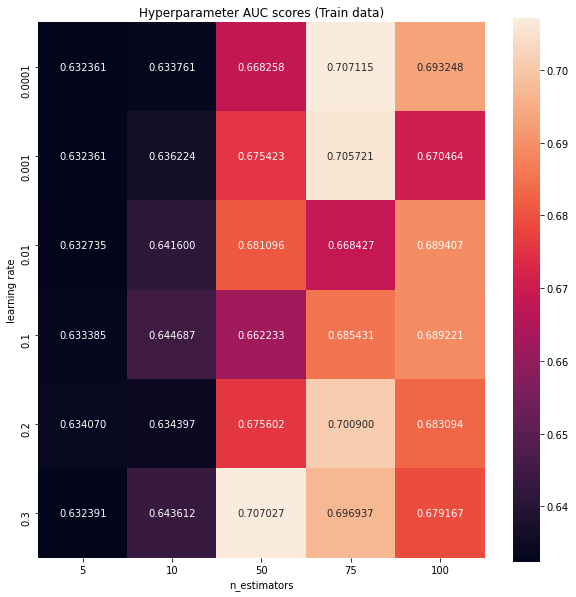

In [ ]:
#Heatmap for hyperparameters
z2 = gcv.cv_results_['mean_test_score']
tr_auc = {5 : [z2[i] for i in range(0,6)],
             10 : [z2[i] for i in range(6,12)],
             50 : [z2[i] for i in range(12,18)],
             75 : [z2[i] for i in range(18,24)],
            100 : [z2[i] for i in range(24,30)]}
df = pd.DataFrame(tr_auc)
fig, ax = plt.subplots(figsize=(10,10))
heatmap = sns.heatmap(df,annot=True,square=True,fmt='f')
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(learning_rate)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.xlabel("n_estimators")
plt.ylabel("learning rate")
plt.title("Hyperparameter AUC scores (Train data)")
plt.show()


In [ ]:
#train model with best params
lear_rate = gcv.best_params_['learning_rate']
n_estm = gcv.best_params_['n_estimators']
final_model = LGBMClassifier(class_weight='balanced',random_state=1,learning_rate=lear_rate ,n_estimators=n_estm)
final_model.fit(x_tr_tfidf,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=75, n_jobs=-1, num_leaves=31,
               objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
from sklearn.metrics import roc_auc_score
y_tr_pred = final_model.predict(x_tr_tfidf)
y_tr_pred_proba = final_model.predict_proba(x_tr_tfidf)
train_score_tfidf = roc_auc_score(y_train,y_tr_pred_proba[:,1])
print("Train AUC score: ",train_score_tfidf)

y_tst_pred = final_model.predict(x_tst_tfidf)
y_tst_pred_proba = final_model.predict_proba(x_tst_tfidf)
test_score_tfidf = roc_auc_score(y_test,y_tst_pred_proba[:,1])
print("Test AUC score: ",test_score_tfidf)

Train AUC score:  0.8849804874059213
Test AUC score:  0.7158669701480443


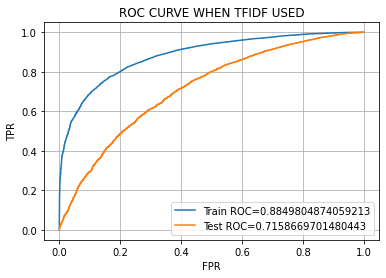

In [ ]:
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve,auc

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,y_tr_pred_proba[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test,y_tst_pred_proba[:,1])
plt.plot(train_fpr, train_tpr, label='Train ROC='+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test ROC='+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE WHEN TFIDF USED")
plt.grid()
plt.show()

-------------------- Confusion matrix of Train data --------------------


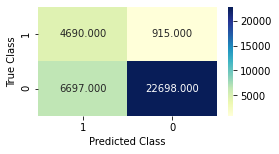

-------------------- Confusion matrix of Test data --------------------


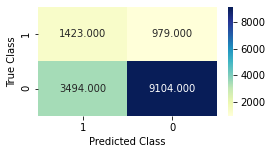

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

train_conf_matrix = confusion_matrix(y_train, y_tr_pred)
test_conf_matrix = confusion_matrix(y_test, y_tst_pred)
labels = [1,0]

print("-"*20, "Confusion matrix of Train data", "-"*20)
plt.figure(figsize=(4,2))
sns.heatmap(train_conf_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
print("-"*20, "Confusion matrix of Test data", "-"*20)
plt.figure(figsize=(4,2))
sns.heatmap(test_conf_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

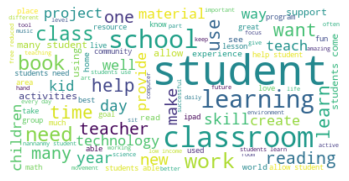

In [ ]:
#getting FP points and creating WordCloud out of FP(Essay data)
fp_idx=[]
for i in range(len(y_test)):
  if(y_test[i]==0 and y_tst_pred[i]==1):
    fp_idx.append(i)
len(fp_idx)

essay = pd.Series(x_test['essay'])
word_set=[]
for i in fp_idx:
  word_set.extend(essay.iat[i])

word_set=''.join(word_set)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(word_set)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

979


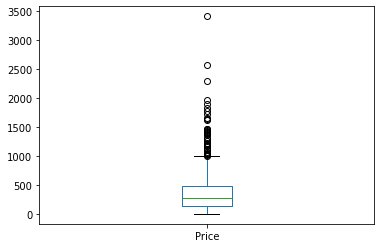

In [ ]:
#box plot for FP(Price)
price = pd.Series(x_test['price'])
print(len(fp_idx))
FP_price=[]
for i in fp_idx:
  FP_price.append(price.iloc[i])

d = pd.DataFrame(FP_price,columns=['Price'])
d.plot.box()

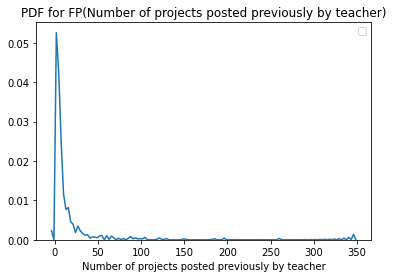

In [ ]:
#pdf for teacher number of previously posted projects
no_of_posted_proj = pd.Series(x_test['teacher_number_of_previously_posted_projects'])
FP_posted_cnt=[]
for i in fp_idx:
  FP_posted_cnt.append(no_of_posted_proj.iloc[i])

sns.distplot(FP_posted_cnt,hist=False)
plt.xlabel("Number of projects posted previously by teacher")
plt.legend(['PDF'])
plt.title("PDF for FP(Number of projects posted previously by teacher)")
plt.show()

# SET - II (TFIDF W2V)

In [ ]:
gcv = GridSearchCV(clf,parameters,n_jobs=-1,scoring='roc_auc') #training for train data points
gcv.fit(x_tr_tfidf_w2v,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=1, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0

In [ ]:
print("Best parameters for Train data: ",gcv.best_params_)
print("Best score for Train data: ",gcv.best_score_)

Best parameters for Train data:  {'learning_rate': 0.1, 'n_estimators': 75}
Best score for Train data:  0.6850387664769096


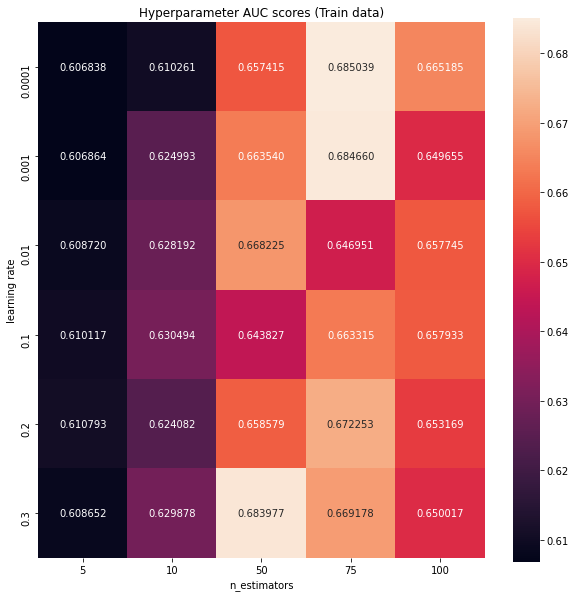

In [ ]:
#Heatmap for hyperparameters
z2 = gcv.cv_results_['mean_test_score']
tr_auc = {5 : [z2[i] for i in range(0,6)],
             10 : [z2[i] for i in range(6,12)],
             50 : [z2[i] for i in range(12,18)],
             75 : [z2[i] for i in range(18,24)],
            100 : [z2[i] for i in range(24,30)]}
df = pd.DataFrame(tr_auc)
fig, ax = plt.subplots(figsize=(10,10))
heatmap = sns.heatmap(df,annot=True,square=True,fmt='f')
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(learning_rate)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.xlabel("n_estimators")
plt.ylabel("learning rate")
plt.title("Hyperparameter AUC scores (Train data)")
plt.show()


In [ ]:
#train model with best params
lear_rate = gcv.best_params_['learning_rate']
n_estm = gcv.best_params_['n_estimators']
final_model = LGBMClassifier(class_weight='balanced',random_state=1,learning_rate=lear_rate ,n_estimators=n_estm)
final_model.fit(x_tr_tfidf_w2v,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=75, n_jobs=-1, num_leaves=31,
               objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
from sklearn.metrics import roc_auc_score
y_tr_pred = final_model.predict(x_tr_tfidf_w2v)
y_tr_pred_proba = final_model.predict_proba(x_tr_tfidf_w2v)
train_score_tfidf = roc_auc_score(y_train,y_tr_pred_proba[:,1])
print("Train AUC score: ",train_score_tfidf)

y_tst_pred = final_model.predict(x_tst_tfidf_w2v)
y_tst_pred_proba = final_model.predict_proba(x_tst_tfidf_w2v)
test_score_tfidf = roc_auc_score(y_test,y_tst_pred_proba[:,1])
print("Test AUC score: ",test_score_tfidf)

Train AUC score:  0.8987210590500456
Test AUC score:  0.6845138774786688


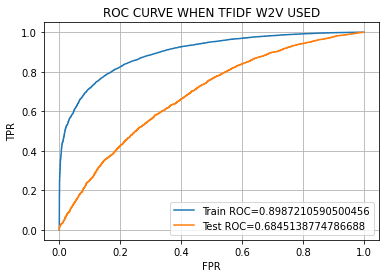

In [ ]:
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve,auc

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,y_tr_pred_proba[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test,y_tst_pred_proba[:,1])
plt.plot(train_fpr, train_tpr, label='Train ROC='+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test ROC='+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE WHEN TFIDF W2V USED")
plt.grid()
plt.show()

-------------------- Confusion matrix of Train data --------------------


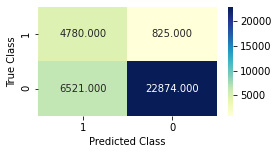

-------------------- Confusion matrix of Test data --------------------


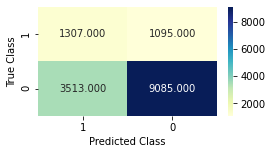

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

train_conf_matrix = confusion_matrix(y_train, y_tr_pred)
test_conf_matrix = confusion_matrix(y_test, y_tst_pred)
labels = [1,0]

print("-"*20, "Confusion matrix of Train data", "-"*20)
plt.figure(figsize=(4,2))
sns.heatmap(train_conf_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
print("-"*20, "Confusion matrix of Test data", "-"*20)
plt.figure(figsize=(4,2))
sns.heatmap(test_conf_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

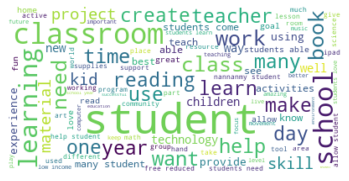

In [ ]:
#getting FP points and creating WordCloud out of FP(Essay data)
fp_idx=[]
for i in range(len(y_test)):
  if(y_test[i]==0 and y_tst_pred[i]==1):
    fp_idx.append(i)
len(fp_idx)

essay = pd.Series(x_test['essay'])
word_set=[]
for i in fp_idx:
  word_set.extend(essay.iat[i])

word_set=''.join(word_set)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(word_set)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

1095


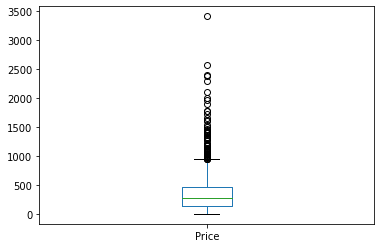

In [ ]:
#box plot for FP(Price)
price = pd.Series(x_test['price'])
print(len(fp_idx))
FP_price=[]
for i in fp_idx:
  FP_price.append(price.iloc[i])

d = pd.DataFrame(FP_price,columns=['Price'])
d.plot.box()

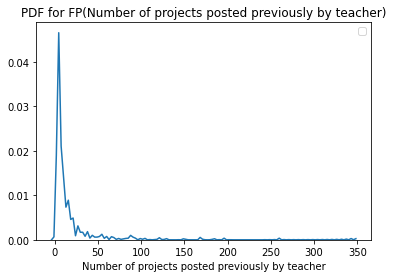

In [ ]:
#pdf for teacher number of previously posted projects
no_of_posted_proj = pd.Series(x_test['teacher_number_of_previously_posted_projects'])
FP_posted_cnt=[]
for i in fp_idx:
  FP_posted_cnt.append(no_of_posted_proj.iloc[i])

sns.distplot(FP_posted_cnt,hist=False)
plt.xlabel("Number of projects posted previously by teacher")
plt.legend(['PDF'])
plt.title("PDF for FP(Number of projects posted previously by teacher)")
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [ ]:
from prettytable import PrettyTable
l = [['TFIDF','lightgbm','learning_rate = 0.1,  n_estimators= 75',0.7158],
     ['TFIDF W2V','lightgbm','learning_rate = 0.1, n_estimators = 75',0.6845]]
table = PrettyTable(['Vectorizer', 'Model', 'Hyper Parameter', 'AUC'])
for rec in l:
  table.add_row(rec)
print(table)

+------------+----------+----------------------------------------+--------+
| Vectorizer |  Model   |            Hyper Parameter             |  AUC   |
+------------+----------+----------------------------------------+--------+
|   TFIDF    | lightgbm | learning_rate = 0.1,  n_estimators= 75 | 0.7158 |
| TFIDF W2V  | lightgbm | learning_rate = 0.1, n_estimators = 75 | 0.6845 |
+------------+----------+----------------------------------------+--------+
